In [1]:
import pandas as pd
import pandasql as ps #pandasql uses the SQLite syntax.
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
titanic = pd.read_csv("titanic.csv")

In [3]:
ps.sqldf("""SELECT *
            FROM titanic 
            LIMIT 5""")

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
titanic['PassengerID']=range(1,1+len(titanic))
titanic=titanic.rename(columns={'home.dest':'home_dest'})

## Total Survival Passengers

In [5]:
ps.sqldf("""SELECT COUNT(*)
            FROM titanic
            WHERE survived=1  """)

,COUNT(*)
0,500


## Survived by title

In [6]:
titanic=ps.sqldf("""SELECT *,
                    SUBSTR(name, INSTR(name, ',')+2, INSTR(name, '.')-INSTR(name, ',')-2) AS title
                    FROM titanic  """)
# SUBSTR: Extract a substring from the text in a column (text, start position, extract n characters)
# INSTR: returns the position of the second string in the first string.

In [7]:
ps.sqldf("""SELECT title, COUNT() AS Count, round(avg(survived),4) as survival_rate
            FROM titanic
            GROUP BY title
            ORDER BY survival_rate DESC            
            """)

,title,Count,survival_rate
0,the Countess,1,1.0000
1,Sir,1,1.0000
2,Mme,1,1.0000
3,Mlle,2,1.0000
4,Lady,1,1.0000
5,Dona,1,1.0000
6,Mrs,197,0.7868
7,Miss,260,0.6769
8,Master,61,0.5082
9,Ms,2,0.5000


## Survived by title_grouping:

In [8]:
titanic=ps.sqldf("""SELECT *,
                    CASE when title in ('Dr','Rev','Col','Major','Jonkheer','Sir','Don','Capt') and sex = 'male' then 'Mr'
                         when title in ('Dr','Ms','the Countess','Mme','Lady','Dona') and sex = 'female' then 'Mrs'
                         when title in ('Mlle') then 'Miss' 
                         else title
                    END title_grouping
                    FROM titanic """)

In [9]:
ps.sqldf("""SELECT title_grouping, COUNT() AS Count, round(avg(survived),4) as survival_rate
            FROM titanic
            GROUP BY title_grouping
            ORDER BY survival_rate DESC""")

,title_grouping,Count,survival_rate
0,Mrs,204,0.7892
1,Miss,262,0.6794
2,Master,61,0.5082
3,Mr,782,0.1662
4,None,1,NaN


## Survived by Class:

In [10]:
ps.sqldf("""SELECT pclass, COUNT(*) AS Count, round(avg(survived),4) as survival_rate
            FROM titanic 
            GROUP BY pclass
            ORDER BY survival_rate DESC  """)

,pclass,Count,survival_rate
0,1.0,323,0.6192
1,2.0,277,0.4296
2,3.0,709,0.2553
3,NaN,1,NaN


## Survived by sex:

In [11]:
ps.sqldf("""SELECT sex, COUNT(*) AS Count, round(avg(survived),4) as survival_rate
            FROM titanic 
            GROUP BY sex
            ORDER BY survival_rate DESC  """)

,sex,Count,survival_rate
0,female,466,0.7275
1,male,843,0.1910
2,None,1,NaN


## Survived by Age

In [12]:
titanic=ps.sqldf(""" SELECT *,
                     CASE WHEN age is NULL THEN 'Missing'
                          WHEN age <18 THEN '1-17'
                      WHEN age <60 THEN '18-60'
                     ELSE '60+' 
                     END AS age_interval
                     FROM titanic """)

In [13]:
ps.sqldf(""" SELECT age_interval, COUNT(*) AS Count, round(avg(survived),4) as survival_rate
             FROM titanic
             GROUP BY age_interval
             ORDER BY survival_rate DESC
             """)

,age_interval,Count,survival_rate
0,1-17,154,0.5260
1,18-60,852,0.3920
2,60+,40,0.3000
3,Missing,264,0.2776


#### Oldest passengers

In [14]:
ps.sqldf("""SELECT passengerID, name, sex, survived, MAX(age) as age
            FROM titanic  """)

,PassengerID,name,sex,survived,age
0,15,"Barkworth, Mr. Algernon Henry Wilson",male,1.0,80.0


#### Youngest passanger

In [15]:
ps.sqldf("""SELECT passengerID, name, sex, survived, MIN(age) as age
            FROM titanic  """)

,PassengerID,name,sex,survived,age
0,764,"Dean, Miss. Elizabeth Gladys ""Millvina""",female,1.0,0.1667


## Survived by Embarked

In [16]:
ps.sqldf("""SELECT embarked, COUNT(*) as Count, round(avg(survived),4) as survival_rate
            FROM titanic
            GROUP BY embarked
            ORDER BY survival_rate DESC""")

,embarked,Count,survival_rate
0,None,3,1.0000
1,C,270,0.5556
2,Q,123,0.3577
3,S,914,0.3326


## Survived by boat ID

In [17]:
ps.sqldf(""" SELECT  boat, COUNT(*) AS Count, round(avg(survived),4) as survival_rate
             FROM  titanic
             GROUP BY boat
             ORDER BY survival_rate DESC""")

,boat,Count,survival_rate
0,C D,2,1.0000
1,9,25,1.0000
2,8 10,1,1.0000
3,8,23,1.0000
4,7,23,1.0000
5,6,20,1.0000
6,5 9,1,1.0000
7,5 7,2,1.0000
8,5,27,1.0000
9,4,31,1.0000


## Survived by home dest

In [18]:
ps.sqldf("""SELECT home_dest, COUNT(*) as Count, round(avg(survived),4) as survival_rate
            FROM titanic
            GROUP BY home_dest
            ORDER BY Count DESC
            LIMIT 20""")

,home_dest,Count,survival_rate
0,None,565,0.2713
1,"New York, NY",64,0.6250
2,London,14,0.3571
3,"Montreal, PQ",10,0.4000
4,"Paris, France",9,0.8889
5,"Cornwall / Akron, OH",9,0.8889
6,"Winnipeg, MB",8,0.5000
7,"Wiltshire, England Niagara Falls, NY",8,0.0000
8,"Philadelphia, PA",8,0.3750
9,"Sweden Winnipeg, MN",7,0.0000


## Aggregating Information

In [19]:
ps.sqldf(""" SELECT  sex,
                     embarked,
                     AVG(age) AS avg_age,
                     MIN(age) AS min_age,
                     MAX(age) AS max_age,
                     COUNT(PassengerID) AS total_passengers,
                     COUNT(DISTINCT ticket) as unique_tickets,
                     ROUND(AVG(survived),4) as survival_rate
             FROM titanic
             GROUP BY embarked,sex
             ORDER BY total_passengers DESC
""")

,sex,embarked,avg_age,min_age,max_age,total_passengers,unique_tickets,survival_rate
0,male,S,29.942407,0.3333,80.0,623,541,0.1701
1,female,S,27.877210,0.1667,76.0,291,211,0.6804
2,male,C,33.284357,0.4167,71.0,157,140,0.3057
3,female,C,31.224490,0.7500,64.0,113,77,0.9027
4,male,Q,31.557692,2.0000,70.5,63,58,0.1111
5,female,Q,25.458333,15.0000,39.0,60,57,0.6167
6,female,None,50.000000,38.0000,62.0,2,1,1.0000
7,None,None,NaN,NaN,NaN,1,0,NaN


# Visualisation

In [20]:
def sub_barplot(X,Y,Xlab,Ylab,titles,nb_rows,nb_columns,fig):
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=1)
    itm=0
    cursor=1
    for i in titles:
        plt.subplot(nb_rows, nb_columns, cursor)
        plt.title('{}'.format(i), fontsize = 12)
        plt.xlabel(Xlab[itm], fontsize = 12)
        plt.ylabel(Ylab[itm], fontsize = 12)
        plt.xticks(rotation=60)
        sns.barplot(X[itm],Y[itm])
        cursor += 1
        itm += 1
    plt.show()

In [21]:
survived_passengers = titanic.groupby(['survived']).PassengerID.count().sort_values(ascending=False)
survived_sex= titanic[titanic.survived==1].groupby(['sex']).PassengerID.count().sort_values(ascending=False)
survived_class= titanic[titanic.survived==1].groupby(['pclass']).PassengerID.count().sort_values(ascending=False)
survived_age= titanic[titanic.survived==1].groupby(['age_interval']).PassengerID.count().sort_values(ascending=False)
survived_embarked= titanic[titanic.survived==1].groupby(['embarked']).PassengerID.count().sort_values(ascending=False)
survived_boat= titanic[titanic.survived==1].groupby(['boat']).PassengerID.count().sort_values(ascending=False).head(30)
survived_cabin= titanic[titanic.survived==1].groupby(['cabin']).PassengerID.count().sort_values(ascending=False).head(20)
survived_home= titanic[titanic.survived==1].groupby(['home_dest']).PassengerID.count().sort_values(ascending=False).head(10)

/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/lib/python3/dist-packages/seaborn/_decorators.py:36: 

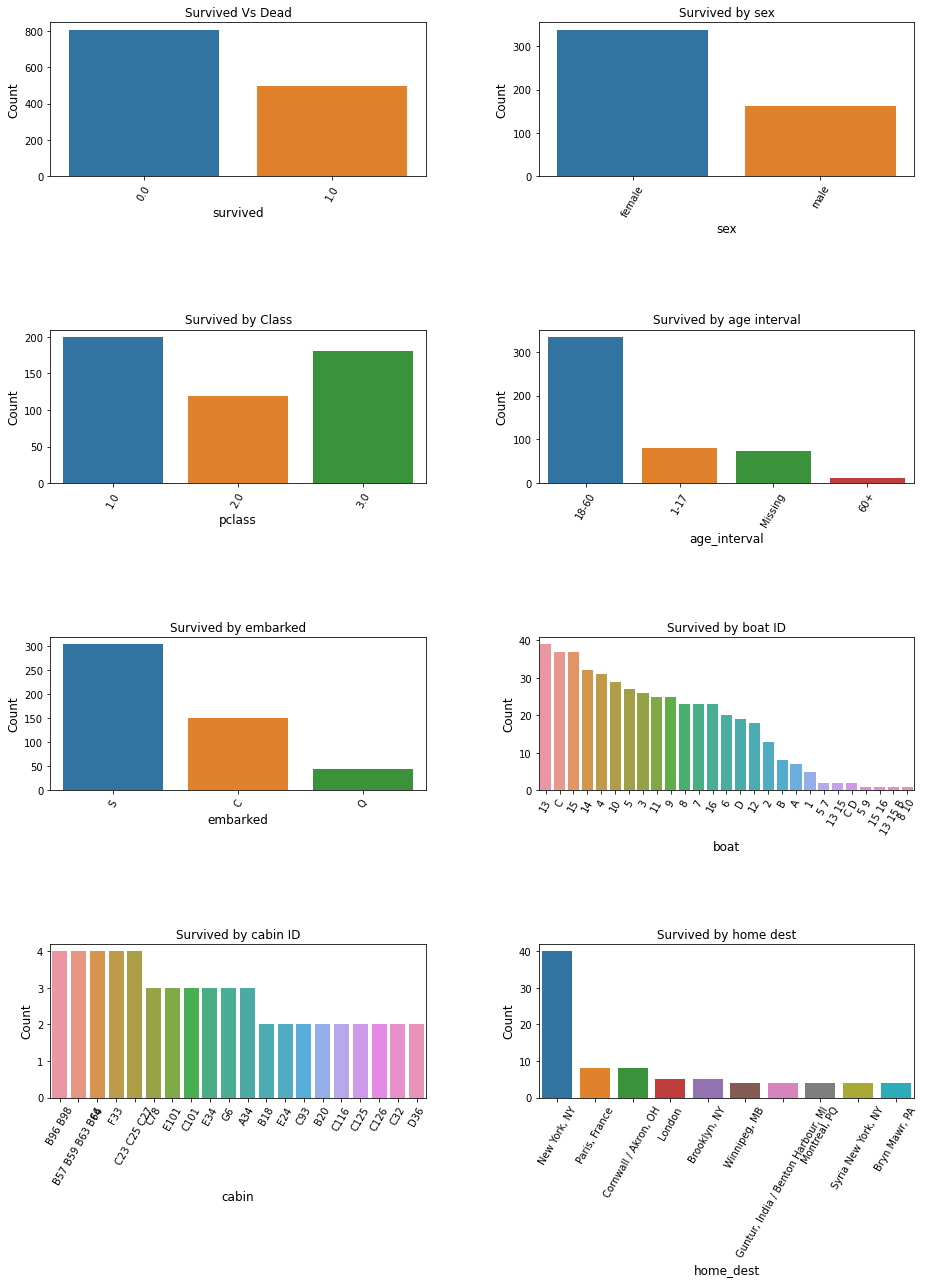

In [22]:
X=[survived_passengers.index, survived_sex.index, survived_class.index, survived_age.index, survived_embarked.index, survived_boat.index,survived_cabin.index,survived_home.index] 
Y=[survived_passengers.values, survived_sex.values, survived_class.values, survived_age.values, survived_embarked.values, survived_boat.values,survived_cabin.values,survived_home.values] 
Xlab=["Survived", "sex", "class","age interval", "embarked", "boat ID", "cabin ID", "home dest"]                                                  
Ylab=['Count','Count','Count','Count','Count','Count','Count','Count']  
titles = ['Survived Vs Dead', 'Survived by sex', 'Survived by Class', 'Survived by age interval', 'Survived by embarked', 'Survived by boat ID', 'Survived by cabin ID', 'Survived by home dest']
fig = plt.figure(figsize=(15,40))
sub_barplot(X,Y,Xlab,Ylab,titles,8,2,fig)